In [1]:
from collections import defaultdict

import time 
import random
import numpy as np

import torch
import torch.nn as nn

In [2]:
gpu_id = "1"

In [3]:
device = torch.device("cuda:" + gpu_id if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=1)

In [5]:
word2index = defaultdict(lambda : len(word2index))
tag2index = defaultdict(lambda : len(tag2index))

In [6]:
def read_data(data_path, sep):
    
    with open(data_path) as f:
        
        data = f.read().split("\n")
        
        for line in data:
            tmp = line.lower().strip().split(sep)
            
            if len(tmp) != 2:
                continue
            
            tag, sentence = tmp
            yield ([word2index[word] for word in sentence.split()], tag2index[tag])

In [7]:
train_data = list(read_data("../../cmu_data/classes/train.txt", " ||| "))
UNK = word2index["unk"]
word2index = defaultdict(lambda : UNK, word2index)
dev = list(read_data("../../cmu_data/classes/test.txt", " ||| "))
vocab_size = len(word2index)
tag_size = len(tag2index)

In [14]:
class DeepModel_Dropout(nn.Module):
    
    def __init__(self, vocab_size: int, embedding_size: int, h_size_list: list, tag_size: int):
        
        super(DeepModel_Dropout, self).__init__()
        
        self.h_size_list = h_size_list
        
        self.embedding = nn.Embedding(vocab_size, embedding_size) # (input_length, embedding_size)
        
        self.linear = nn.ModuleList([
            nn.Linear(embedding_size if i == 0 else self.h_size_list[i-1], self.h_size_list[i])
            for i in range(len(self.h_size_list))
        ])
        
        self.dropout = nn.Dropout()
        
        self.output_layer = nn.Linear(self.h_size_list[-1], tag_size)
        
        self.init_weights()
        
    def init_weights(self):
        
        nn.init.xavier_normal_(self.embedding.weight)
        
        for h_layer in self.linear:
            nn.init.xavier_normal_(h_layer.weight)
            
        nn.init.xavier_normal_(self.output_layer.weight)
    
    def forward(self, inputs: torch.tensor):
        
        # inputs:(input_length, )
        
        inputs = self.embedding(inputs) # (input_length, embedding_size)
        
        inputs = torch.sum(inputs, dim=0, keepdim=True) # (1, embedding_size)
        
        for h_layer in self.linear:
            
            inputs = torch.tanh(h_layer(inputs))
            self.dropout(inputs)
        
        outputs = self.output_layer(inputs) # (1, tag_size)
        return outputs

In [32]:
net = DeepModel_Dropout(vocab_size, 16, [16, 16, 16], tag_size).to(device)

In [33]:
net.modules

<bound method Module.modules of DeepModel_Dropout(
  (embedding): Embedding(18646, 16)
  (linear): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout): Dropout(p=0.5)
  (output_layer): Linear(in_features=16, out_features=5, bias=True)
)>

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [35]:
loss_trace = []
acc_trace_dev = []
acc_trace_train = []

In [36]:
train_tensor = [(torch.tensor(sent).to(device), torch.tensor([tag]).to(device)) for sent, tag in train_data]
dev_tensor = [(torch.tensor(sent).to(device), tag) for sent, tag in dev]

In [37]:
EPOCH = 50

for epoch in range(EPOCH):
    
    random.shuffle(train_tensor)
    
    start_time = time.time()
    train_loss = 0.0
    
    net.train()
    
    correct_num_train = 0
    
    for sent, tag in train_tensor:
        
        
        output = net(sent)
        
        pred = torch.argmax(output, dim=1)
        
        if pred[0] == tag[0]:
            correct_num_train += 1
        
        loss = criterion(output, tag)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_trace.append(train_loss / len(train_tensor))
    
    print("Epoch: {}, time: {} seconds, loss: {}".format(epoch, time.time() - start_time, train_loss / len(train_tensor)))
    print("Epoch: {}, acc of train data :{}".format(epoch, correct_num_train / len(train_tensor)))
    
    acc_trace_train.append(correct_num_train / len(train_tensor))
    
    correct_num_dev = 0
    
    with torch.no_grad():
        net.eval()
        
        for sent, tag in dev_tensor:
            
            output = net(sent)
            pred = torch.argmax(output, dim=1) # (1, )
            
            if pred[0] == tag:
                correct_num_dev += 1
    
    acc_trace_dev.append(correct_num_dev / len(dev_tensor))
    print("Epoch: {}, acc of test data: {}".format(epoch, correct_num_dev / len(dev_tensor)))

Epoch: 0, time: 38.19147324562073 seconds, loss: 1.420920485616679
Epoch: 0, acc of train data :0.3657537453183521
Epoch: 0, acc of test data: 0.4158371040723982
Epoch: 1, time: 37.3149037361145 seconds, loss: 0.9779579123335608
Epoch: 1, acc of train data :0.6006554307116105
Epoch: 1, acc of test data: 0.39773755656108595
Epoch: 2, time: 37.040273904800415 seconds, loss: 0.6038207867521137
Epoch: 2, acc of train data :0.7855805243445693
Epoch: 2, acc of test data: 0.39819004524886875
Epoch: 3, time: 38.66896629333496 seconds, loss: 0.37695637627850087
Epoch: 3, acc of train data :0.8735955056179775
Epoch: 3, acc of test data: 0.3769230769230769
Epoch: 4, time: 38.93959450721741 seconds, loss: 0.2548108620478419
Epoch: 4, acc of train data :0.9119850187265918
Epoch: 4, acc of test data: 0.36606334841628957
Epoch: 5, time: 21.91142702102661 seconds, loss: 0.17013324166505078
Epoch: 5, acc of train data :0.943937265917603
Epoch: 5, acc of test data: 0.36470588235294116
Epoch: 6, time: 18

In [38]:
import matplotlib.pyplot as plt

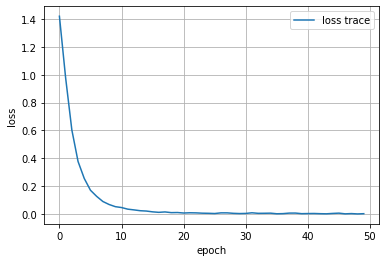

In [39]:
plt.plot(loss_trace, label="loss trace")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

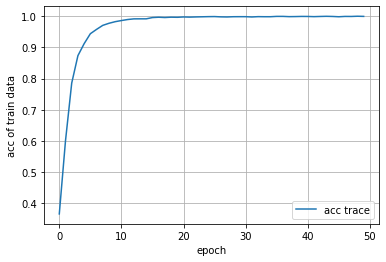

In [40]:
plt.plot(acc_trace_train, label="acc trace")
plt.xlabel("epoch")
plt.ylabel("acc of train data")
plt.grid()
plt.legend()

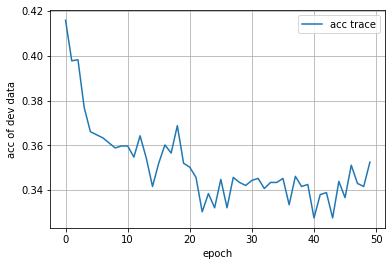

In [41]:
plt.plot(acc_trace_dev, label="acc trace")
plt.xlabel("epoch")
plt.ylabel("acc of dev data")
plt.grid()
plt.legend()